# yield — Definition

yield is a keyword in Python used in a function to make it a generator.<br>
It pauses the function and saves its state, returning a value to the caller.<br>
When the generator is resumed (e.g., using next() or .send()), it continues from where it left off.<br>

Key Points:<br>
Acts like a return, but resumable<br>
Each call to next() resumes from the last yield<br>
Supports two-way communication with .send(value)<br>
Saves memory: yields values one at a time (lazy evaluation)<br>

In [3]:
def num_genrator(n):
    for x in range(n):
        yield x

In [7]:
num = num_genrator(3)
next(num)

0

In [8]:
next(num)

1

In [9]:
next(num)

2

In [10]:
next(num)

StopIteration: 

In [11]:
for x in num_genrator(3):
    print(x)

0
1
2


### Multiple Yields

In [12]:
def greet():
    yield "Hello"
    yield "How are you?"
    yield "Goodbye"

for msg in greet():
    print(msg)


Hello
How are you?
Goodbye


### Chaining with yield from

In [13]:
def nums():
    yield 1
    yield 2

def letters():
    yield 'A'
    yield 'B'

def combined():
    yield from nums()     # delegate to nums()
    yield from letters()  # then to letters()

for x in combined():
    print(x)


1
2
A
B


 # yield as a Two-Way Street

 value = yield something  # send out `something`, receive `value` on next send

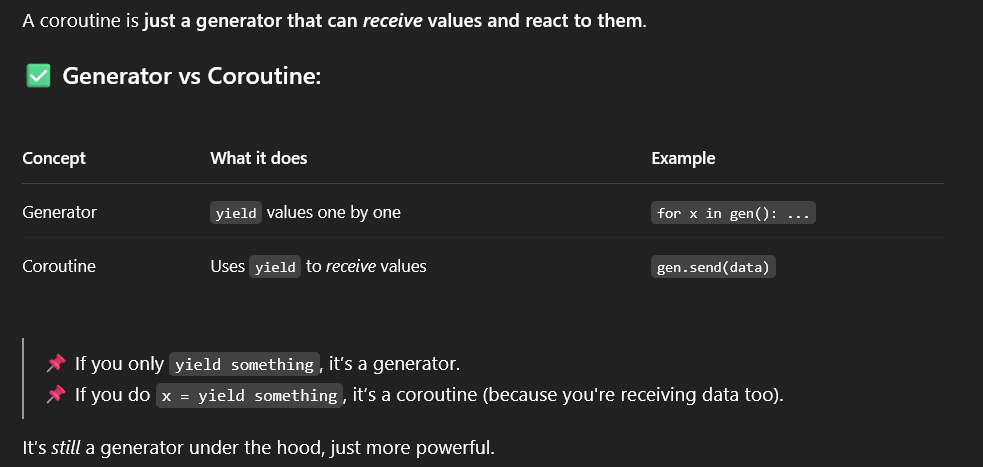

In [19]:
def responder():
    print(" I am ready to respond")
    while True:
        value = yield
        print(f"received {value}")

In [20]:
r = responder()
next(r)  # You must call next() once before the first .send() — this moves it to the first yield.
r.send("hello")
r.send("codo")

 I am ready to respond
received hello
received codo


In [21]:
# Full Example: Accumulator
def running_sum():
    total = 0
    while True:
        value = yield total
        if value is not None:
            total += value

In [22]:
acc = running_sum()
next(acc)

0

In [23]:
acc.send(5)

5

In [25]:
acc.send(10)

15

### Build a Keyword Filter Coroutine

In [27]:
def keyword_filter(keyword):
    # Step 1: say you're ready
    print(f"Filtering for keyword: '{keyword}'")
    while True:
        # Step 2: receive a log line
        log_line = yield
        if log_line.startswith("ERROR"):
            print(log_line)


f = keyword_filter("ERROR")
next(f)  # prime it

f.send("INFO: System booted")
f.send("ERROR: Disk not found")  # this one should print!
f.send("WARNING: Low memory")
f.send("ERROR: CPU overheat")    # this one too!



Filtering for keyword: 'ERROR'
ERROR: Disk not found
ERROR: CPU overheat


ValueError('hELLO')

### throw() to cleanly exit a coroutine

In [37]:
def smart_logger():
    print("Logger started")
    try:
        while True:
            try:
                line = yield
                print("LOG:", line)
            except RuntimeError as e:
                print(f"Runtime Error: {e}")
    except GeneratorExit:
        print("Logger closed")
    
    except Exception as e:
        print(f"Logger error: {e}")


log = smart_logger()
next(log)

log.send("System up")
log.send("User login")

log.throw(RuntimeError("Disk full!"))  # Will be caught inside coroutine
log.close()  # Raises GeneratorExit and prints "Logger closed"


Exception ignored in: <generator object smart_logger at 0x0000028E71F52880>
Traceback (most recent call last):
  File "C:\Users\kumars\AppData\Local\Temp\ipykernel_7996\2282280494.py", line 17, in <module>
RuntimeError: generator ignored GeneratorExit


Logger closed1
Logger started
LOG: System up
LOG: User login
Runtime Error: Disk full!
Logger closed


In [39]:
def watchdog():
    print("Watchdog Started")
    try:
        while True:
            try:
                log_line = yield 
                print(f"received: {log_line}")
            except TimeoutError as e:
                print(f"TimeoutError: {e}")
    except GeneratorExit as e:
        print(f"Watchdog Closed: Shutdown cleanly")
    except Exception as e:
        print(e)

w = watchdog()
next(w)
w.send("Error: OOM")
w.throw(TimeoutError("Got timeout while allocating memoery"))
w.close()

Watchdog Closed: Shutdown cleanly
Watchdog Started
received: Error: OOM
TimeoutError: Got timeout while allocating memoery
Watchdog Closed: Shutdown cleanly


### Example with .throw() for state reset

using .throw() for custom control flow, not just error handling<br>
Below example can also be achieved by .send()<br>
But using throw keeps your data plane (.send()) separate from the control plane (.throw()).

In [ ]:
class Reset(Exception):   # Custom control exception
    def __str__(self, *args, **kwargs):
        super.__str__(self, *args, **kwargs)
        return "Reset Action" 
    
def counter():
    print("Counter Started")
    count = 0
    try:
        while True:
            try:
                msg = yield
                count += 1
                print(f"[{count}] {msg}")
            except Reset as e:
                print(f"{e}: Resetting counter...")
                count = 0
    except GeneratorExit:
        print("Counter stopped cleanly.")


In [50]:
c = counter()
next(c)

c.send("hello")
c.send("world")
c.throw(Reset)           #  resets counter to 0
c.send("again")          # → [1] again
c.close()


Counter Started
[1] hello
[2] world
Resetting counter... Reset Action
[1] again
Counter stopped cleanly.


### Coroutine Pipeline

We’ll build modular coroutine stages that:
<pre>
    🔄 Receive data from the previous stage
    🎯 Optionally filter/transform it
    📤 Send it to the next coroutine in the pipeline
</pre>
Think:
log_generator → filter_errors → counter → printer

In [53]:
def printer():
    try:
        while True:
            item = yield
            print(f"🖨️  {item}")
    except GeneratorExit:
        print("🛑 Printer closed.")

def counter(target):
    try:
        count = 0
        while True:
            log_line = yield
            count += 1
            target.send(f"[{count}] {log_line}")
    except GeneratorExit:
       print("🛑 Counter closed.")
       target.close()

def transform_upper(target):
    try:
        print("transformer Started")
        while True:
            log_line = yield
            target.send(log_line.upper())
    except GeneratorExit:
        print("🛑  Transformer Stopped")
        target.close()

def filter_error(target):
    print("Filter Started")
    try:
        while True:
            log_line = yield
            if "ERROR" in log_line:
                target.send(log_line)
    except GeneratorExit:
        print("🛑 Filter closed.")
        target.close()

In [54]:
p = printer()
c = counter(p)
t = transform_upper(c)
f = filter_error(t)

next(p)
next(c)
next(t)
next(f)

# Feed messages into the pipeline
f.send("INFO: All good")
f.send("ERROR: Disk failure")
f.send("WARNING: CPU high")
f.send("ERROR: Memory leak")

f.close()


transformer Started
Filter Started
🖨️  [1] ERROR: DISK FAILURE
🖨️  [2] ERROR: MEMORY LEAK
🛑 Filter closed.
🛑  Transformer Stopped
🛑 Counter closed.
🛑 Printer closed.
